# Gaussian Processes and Gaussian Process Regression

This notebook will walk through the key mathematical details required to understand what a Gaussian Process is and how Gaussian Process Regression works.


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom, beta

sns.set(rc = {'figure.figsize':(8,4)})

Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a Gaussian Process is fully specified by a mean function and a covariance function

$$p(x) \sim \mathcal{GP}(m(x), k(x,x'))$$

For example, take the mean function equal to 0 and the squared exponential covariance function

$$m(x) = 0$$
$$k(x,x') = \theta_1 \cdot exp \left(- \frac{\theta_2}{2}(x - x')^2 \right)$$

It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function. It is common to take a mean function of 0 as the prior and rely completely on the covariance function for learning.

Let's walk through a Gaussian Process Regression example using the prior GP we just defined above. First we define the mean and covariance functions. We will start with hyperpareters $\sigma_0 = 1$, $\sigma_1=10$. Moreover, we may take the standard deviation at x-value to be $1$.

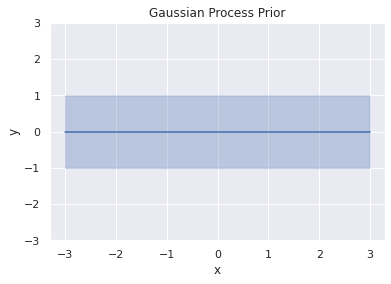

In [2]:
xpts = np.arange(-3, 3, step=0.01)

mean_prior = [0 for x in xpts]

def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.subtract.outer(x,y)**2)

theta = [1, 10]

sigma_0 = exponential_cov(0, 0, theta)

sns.set()
plt.plot(xpts, mean_prior, label="mean");
stdev_plus = [x + sigma_0 for x in mean_prior]
stdev_minus = [x - sigma_0 for x in mean_prior]
plt.fill_between(xpts, stdev_plus, color="b", alpha=0.3);
plt.fill_between(xpts, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Prior");

We have our first Gaussian Process! At each value of on the x axis, we have a normal distribution in y values. Moreover, the mean and standard deviation for each of these normal distributions is 0 and 1 respectively.

Lets take a sample at a random point, say 1, to make our first observation. The default values for np.random.normal() are a mean of 0 and a standard deviation of 1.

In [9]:
x = [1.]
y = [np.random.normal()]
print(y)

# New sigma
sigma_1 = exponential_cov(x, x, theta)

[0.491963042891592]


Now we have our first observation, $(1, -1.0578)$. From here, we will need to use some conditioning formulas for multivariate Gaussian Distributions so we can condition our Gaussian Process prior on this observation and obtain our Posterior. The conditioning property of multivariate Gaussian Distributions gives us the following mean and covariance fucntions for $p(x|y)$

$$\mu = \mu_x + \Sigma_{xy} \Sigma_y^{-1}(y - \mu_y)$$
$$\sigma = \Sigma_x - \Sigma_{xy} \Sigma_y^{-1} \Sigma_{yx}$$

Our first oberservation is $(1, -1.0578)$. We will need to compute the resulting normal distribution at all the remaining points in xpts. To help us understand how that calculation works, let us start with a single unkown point from xpts, say $x=0.7$. We want to know the probability distribution for $y$ at $x=0.7$ given the data we know, by using the formulas above. Let's take $x_0 = 1$ and $x_1 = 0.7$.

Remember! Here $x_0$ and $x_1$ represent normal distributions, it is confusing to keep track of this, I know. Moreover, $x_0$ has been observed and no longer represents a normal distribution, we take the value of $-1.0578$ for $x_0$. (yikes)

$p(x_1 \; | \; x_0 = -1.0578)$

$\mu = \mu_{x_1} + \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} (x_0 - \mu_{x_0})$

$\sigma = \Sigma_{x_1} - \Sigma_{x_1 x_0} \Sigma^{-1}_{x_0} \Sigma_{x_0 x_1}$

Let's calculate this!

In [10]:
# We will need this inverse in our calculations
x_0 = x[0]
y_0 = y[0]

x_1 = 0.7


sigma_inv = np.linalg.inv([[exponential_cov(x_1, x_1, theta)]])

mu = 0 + np.dot([[exponential_cov(0.7, 1, theta)]], sigma_inv).dot(y_0 - 0)

sigma = exponential_cov(x_1, x_1, theta) - np.dot([[exponential_cov(x_1, x_0, theta)]], sigma_inv).dot(exponential_cov(x_0, x_1, theta))

print(mu, sigma)

[[0.31368949]] [[0.59343034]]


Now, lets write a fucntion to do this for us at every point in xpts given our known data.

In [11]:
def predict(x, data, kernel, params, sigma, t):
    # We need to know the variance of the multivariate gaussian 'x', and the 'x_known's in 'data'
    # This results in a list of variances that correspond to the 'x_known's in data. This list is
    # the vector from a larger unknown covariance matrix that specifically represents the variance
    # between the new 'x' and the 'x_known's
    k = [kernel(x, x_known, params) for x_known in data]

    # Compute inverse of known sigma for computations later
    sigma_inv = np.linalg.inv(sigma)

    # Our new prediction for 'x' is a gaussian distribution which is specified by a mean and
    # variance. The mean and variance below are given by the conditoing propery of multivariate
    # Gaussian distributions, p(x_new | known_data) ~ N(y_mean, y_variance), shown below
    y_mean = np.dot(k, sigma_inv).dot(t)
    y_variance = kernel(x, x, params) - np.dot(k, sigma_inv).dot(k)

    return y_mean, y_variance

In [12]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]
y_means, y_sigmas = np.transpose(predictions)


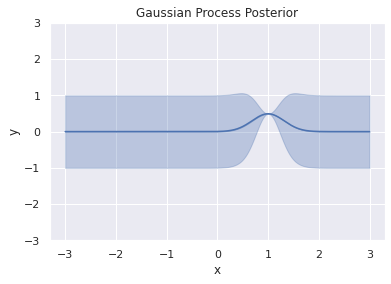

In [14]:
sns.set()
plt.plot(x_pred, y_means, label="mean");
stdev_plus = [y_mean + abs(y_sigma) for y_mean, y_sigma in zip(y_means, y_sigmas)]
stdev_minus = [y_mean - y_sigma for y_mean, y_sigma in zip(y_means, y_sigmas)]
plt.fill_between(x_pred, y_means, stdev_plus, color="b", alpha=0.3);
plt.fill_between(x_pred, y_means, stdev_minus, color="b", alpha=0.3);
plt.ylim(-3, 3);
plt.xlabel("x");
plt.ylabel("y");
plt.title("Gaussian Process Posterior");